In [100]:
# Made by Daniel Crawford
# Student Net ID: dsc160130
# Course: CS6364 - Artificial Intelligence

import torch
import torch.nn as nn
import numpy as np
import cv2
import os
import urllib
import gzip
import time

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Torch setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train hyperparameters
num_epochs = 25
learning_rate = 0.001


# Data hyperparameters
batch_size = 64

# Data details

train_size = 60000
test_size = 10000
data_rows = 28
data_cols = 28
data_classes = 10

# Data
test_data_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz'
test_data_file = 'test_data.gz'
test_labels_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz'
test_labels_file = 'test_labels.gz'
train_data_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz'
train_data_file = 'train_data.gz'
train_labels_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz'
train_labels_file = 'train_labels.gz'


if not os.path.exists(train_data_file):
    urllib.request.urlretrieve(train_data_url, train_data_file)
if not os.path.exists(train_labels_file):
    urllib.request.urlretrieve(train_labels_url, train_labels_file)
if not os.path.exists(test_data_file):
    urllib.request.urlretrieve(test_data_url, test_data_file)
if not os.path.exists(test_labels_file):
    urllib.request.urlretrieve(test_labels_url, test_labels_file)

In [101]:
file_train_data = gzip.GzipFile(train_data_file, 'r')
file_train_data.read(16)
buffer_train_data = file_train_data.read(train_size * data_rows * data_cols)
train_data = np.frombuffer(buffer_train_data, dtype=np.uint8).astype(np.int32)
train_data = train_data.reshape(train_size, 1, data_rows, data_cols)

file_train_labels = gzip.open(train_labels_file, 'r')
file_train_labels.read(8)
buffer_train_labels = file_train_labels.read(train_size)
train_labels = np.frombuffer(buffer_train_labels, dtype=np.uint8).astype(np.int32)

file_test_data = gzip.open(test_data_file, 'r')
file_test_data.read(16)
buffer_test_data = file_test_data.read(test_size * data_rows * data_cols)
test_data = np.frombuffer(buffer_test_data, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(test_size, 1, data_rows, data_cols)

file_test_labels = gzip.open(test_labels_file, 'r')
file_test_labels.read(8)
buffer_test_labels = file_test_labels.read(test_size)
test_labels = np.frombuffer(buffer_test_labels, dtype=np.uint8).astype(np.int32)

In [102]:
train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, test_size=0.1)
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)
valid_data = torch.Tensor(valid_data)
valid_labels = torch.Tensor(valid_labels)
test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

train = torch.utils.data.TensorDataset(train_data, train_labels)
test = torch.utils.data.TensorDataset(test_data, test_labels)
valid = torch.utils.data.TensorDataset(valid_data, valid_labels)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)

In [112]:
class Q1Model(nn.Module):
    def __init__(self, data_num_channels, data_width, data_height, kernel_type):
        kernel = None
        if kernel_type == 'vertical':
            kernel = torch.Tensor([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
        if kernel_type == 'horizontal':
            kernel = torch.Tensor([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

        super(Q1Model, self).__init__()
        self.conv = nn.Conv2d(data_num_channels, data_num_channels, kernel_size=(3, 3), padding=1, stride=1,
                               bias=False)
        self.conv.weight.data[:, :, ] = kernel
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1)
        self.vectorizer = nn.Flatten()
        self.fc = nn.Linear(data_width * data_height * data_num_channels, 100)

    def forward(self, x):
        x = x.reshape(1, 1, *x.shape)
        altered_images = []
        y = x

        y = self.conv(y)
        altered_images.append(y[0][0])
        y = self.relu(y)
        altered_images.append(y[0][0])
        y = self.maxpool(y)
        altered_images.append(y[0][0])

        return self.fc(self.vectorizer(y)), altered_images

class Q2Model(nn.Module):
    def __init__(self, data_classes):
        super(Q2Model, self).__init__()

        self.cnn_layers = nn.ModuleList([
            nn.Conv2d(1, 4, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4,4, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ])

        self.linear_layers = nn.ModuleList([
            nn.Flatten(),
            nn.Linear(4 * 7 * 7, data_classes),
            nn.Softmax(dim=1)
        ])

    def forward(self, x):
        y = x

        for layer in self.cnn_layers:
            y = layer(y)

        for layer in self.linear_layers:
            y = layer(y)
        return y

class Q3Model(nn.Module):
    def __init__(self, data_classes):
        super(Q3Model, self).__init__()

        self.cnn_layers = nn.ModuleList([
            nn.Conv2d(1, 6, kernel_size=(5,5), stride=(1,1), padding=(2,2)),
            nn.AvgPool2d((2,2), stride=(2,2)),
            nn.Conv2d(6, 16, kernel_size=(5,5), stride=(1,1), padding=(0,0)),
            nn.AvgPool2d((2,2), stride=(2,2)),
        ])

        self.linear_layers = nn.ModuleList([
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Linear(120, 84),
            nn.Linear(84, 10),
            nn.Softmax(dim=1)
        ])

    def forward(self, x):
        y = x

        for layer in self.cnn_layers:
            y = layer(y)

        for layer in self.linear_layers:
            y = layer(y)
        return y

In [121]:
def train_model(model, optimizer, criterion, device, train_loader, test_loader, valid_loader, num_epochs):
    model = model.to(device)
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        train_loss = 0
        n = 0
        tq = tqdm(train_loader)
        tq.set_description('Epoch {0:d}, Average Train Loss: {1:5.6f}'.format(epoch, 0))
        model.train()
        for i, data in enumerate(tq):
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)

            outputs = model(batch)
            optimizer.zero_grad()
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(batch)
            n += len(batch)
            tq.set_description('Epoch {0:d}, Average Train Loss: {1:5.6f}'.format(epoch,train_loss / n,))
        train_losses.append(train_loss / n)


        model.eval()
        train_len = 0
        train_correct = 0
        train_loss = 0
        for batch, labels in train_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels.long())
            train_loss += loss.item() * len(batch)
            train_len += len(labels)
            train_correct += (predicted == labels).sum().item()

        valid_loss = 0
        valid_len = 0
        valid_correct = 0
        model.eval()
        for batch, labels in valid_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels.long())
            valid_loss += loss.item() * len(batch)
            _, predicted = torch.max(outputs.data, 1)
            valid_len += len(labels)
            valid_correct += (predicted == labels).sum().item()
        # print('Train Accuracy {0: 3.2f}, Train Average Loss: {1:5.6f}\n'
        #       'Valid Accuracy: {2:3.2f}, Valid Average Loss: {3:5.6f}'.format(train_correct / train_len * 100,
        #                                                                       train_loss / train_len,
        #                                                                       valid_correct / valid_len * 100,
        #                                                                       valid_loss / valid_len))
        valid_losses.append(valid_loss / valid_len)
        time.sleep(0.1)
    print('Valid Accuracy: ', valid_correct / valid_len * 100)
    print('Train Accuracy: ', train_correct / train_len * 100)

    test_predictions = []
    for batch, labels in test_loader:
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions += list(predicted.data.numpy())
    return train_losses, valid_losses, test_predictions

def q1():
    img = cv2.imread('Q1.jpg', cv2.IMREAD_GRAYSCALE)
    img = torch.Tensor(img)
    vert_model = Q1Model(1, img.shape[0], img.shape[1], 'vertical')
    _, images = vert_model(img)
    for image in images:
        image = image.detach().numpy()
        imshow(image, cmap='gray')
        plt.show()
    hori_model = Q1Model(1, img.shape[0], img.shape[1], 'horizontal')
    _, images = hori_model(img)
    for image in images:
        image = image.detach().numpy()
        imshow(image, cmap='gray')
        plt.show()

def q2():
    model = Q2Model(data_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    train_losses, valid_losses, test_predictions = train_model(model, optimizer, criterion, device, train_loader,
                                                               test_loader, valid_loader, num_epochs)
    print('Test Accuracy: ', np.sum(np.array(test_predictions) == test_labels.numpy()) / len(test_predictions) * 100)
    epochs_list = list(range(num_epochs))
    plt.plot(epochs_list, train_losses, label='Training Loss')
    plt.plot(epochs_list, valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss (Cross Entropy)')
    plt.legend()
    plt.show()


def q3():
    model = Q3Model(data_classes)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    train_losses, valid_losses, test_predictions = train_model(model, optimizer, criterion, device, train_loader,
                                                               test_loader, valid_loader, num_epochs)
    print('Test Accuracy: ', np.sum(np.array(test_predictions) == test_labels.numpy()) / len(test_predictions) * 100)
    epochs_list = list(range(num_epochs))
    plt.plot(epochs_list, train_losses, label='Training Loss')
    plt.plot(epochs_list, valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss (Cross Entropy)')
    plt.legend()
    plt.show()


QUESTION 1: 


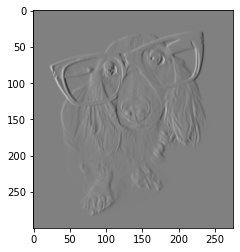

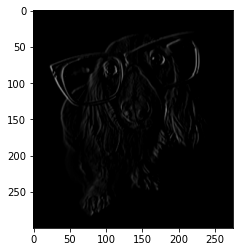

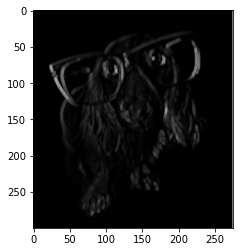

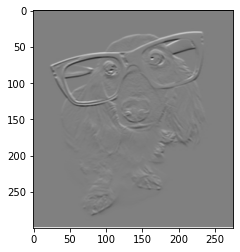

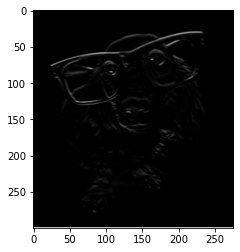

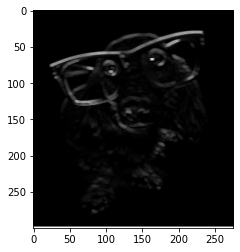

In [105]:
print('QUESTION 1: ')
q1()

Data visualization: 


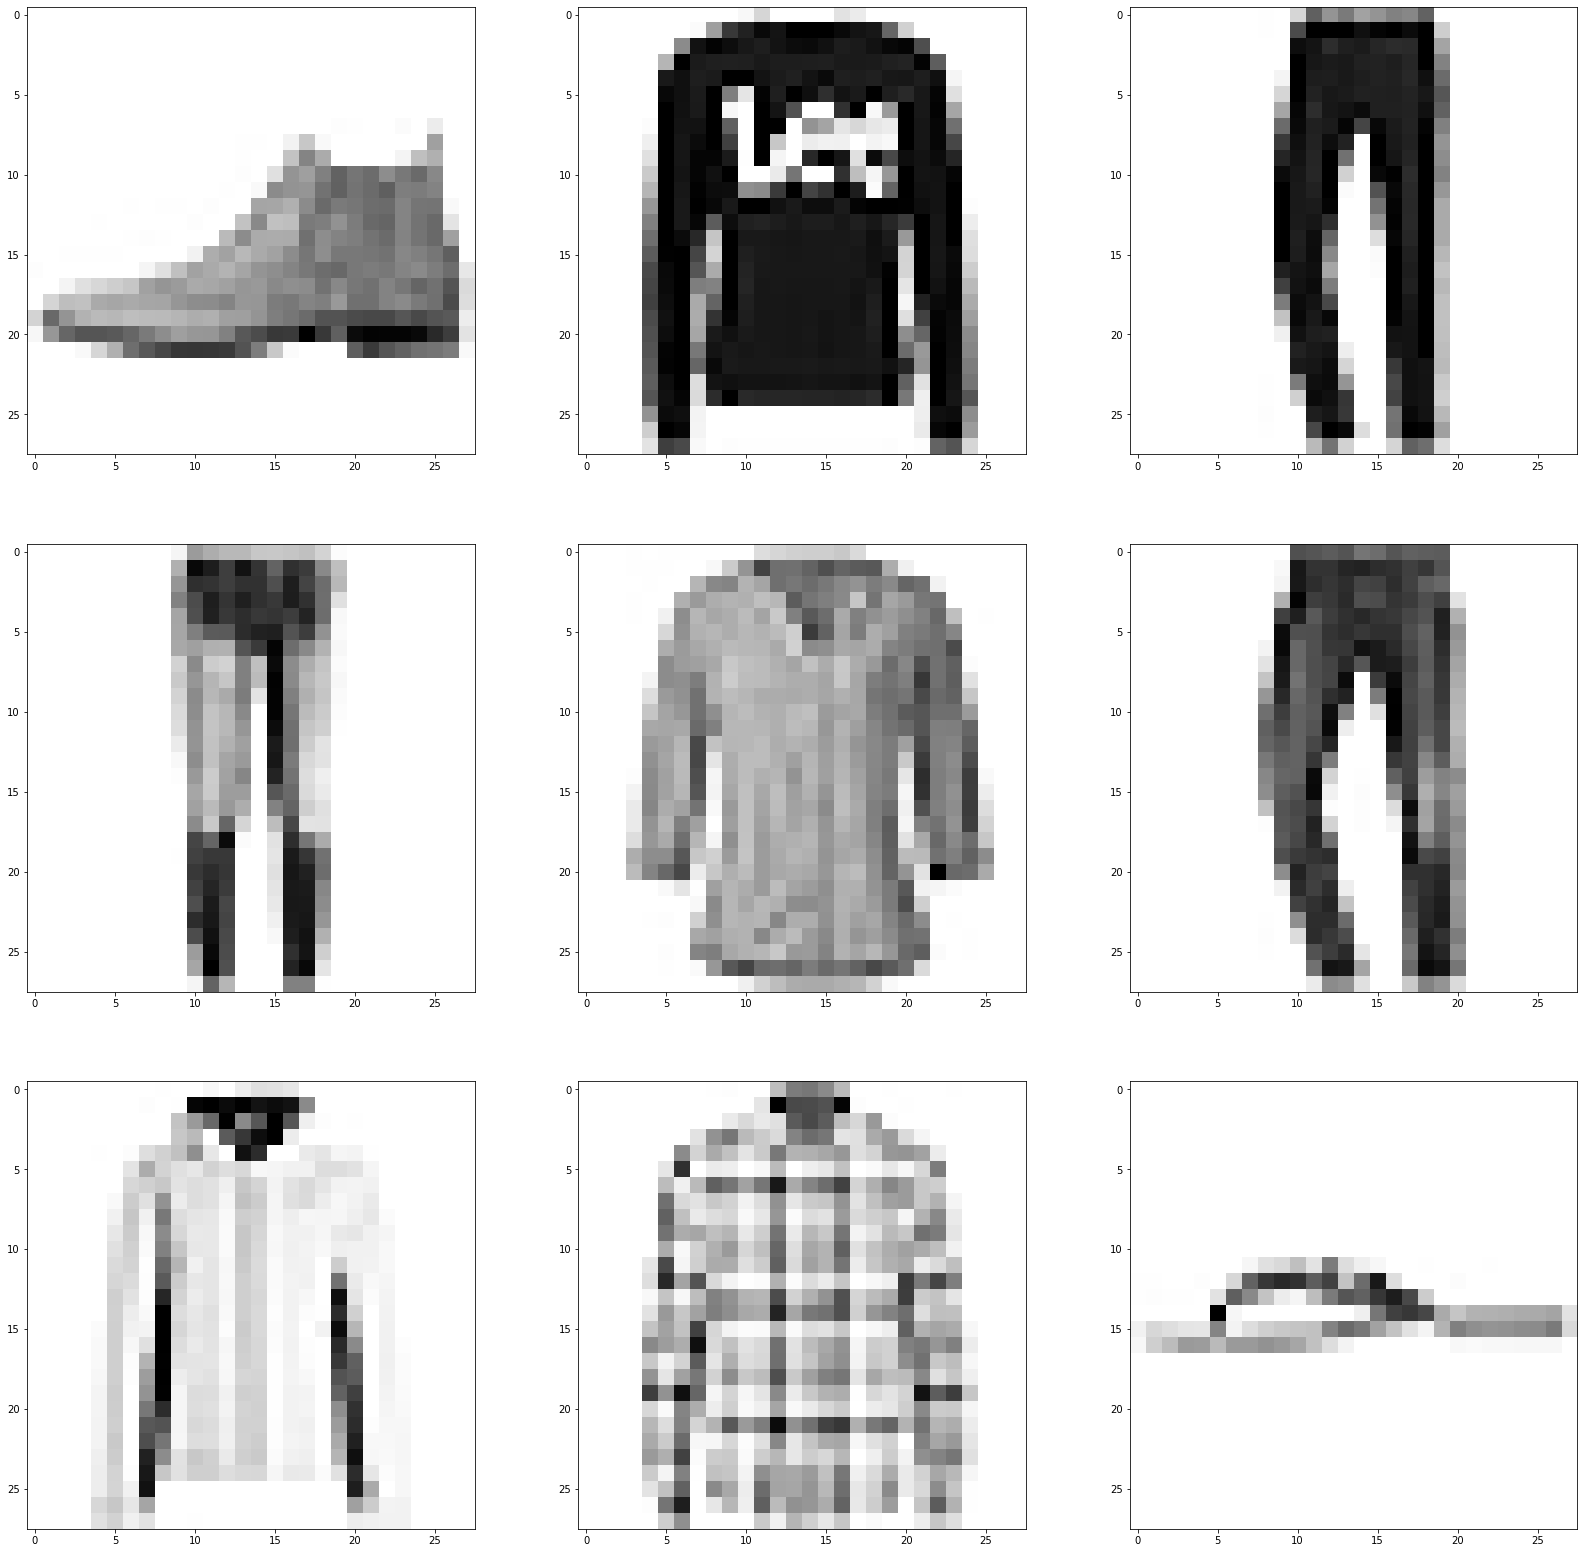

In [106]:
print('Data visualization: ')
fig, ax = plt.subplots(3, 3, figsize=(data_rows, data_cols))
for i in range(9):
    img = test_data[i, :, :, :].reshape((data_rows, data_cols))
    row = i // 3
    col = i % 3
    ax[row][col].imshow(img, cmap='Greys')
plt.show()

Epoch 24, Average Train Loss: 1.568732: 100%|██████████| 844/844 [00:05<00:00, 162.89it/s]


QUESTION 2: 
Valid Accuracy:  0.8826666666666667
Train Accuracy:  0.8888703703703704
Test Accuracy:  87.44


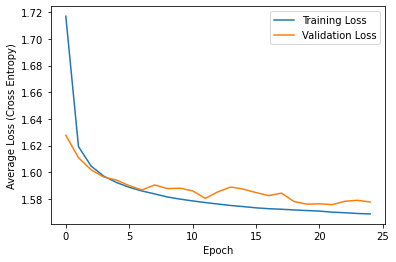

In [110]:
print('QUESTION 2: ')
q2()

Epoch 24, Average Train Loss: 1.617888: 100%|██████████| 844/844 [00:08<00:00, 94.18it/s] 


QUESTION 3: 
Valid Accuracy:  0.8381666666666666
Train Accuracy:  0.8402407407407407
Test Accuracy:  82.26


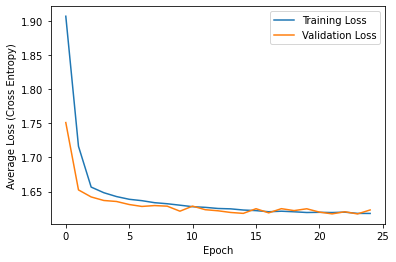

In [122]:
print('QUESTION 3: ')
q3()